In [1]:
from __future__ import print_function

# importing relevant modules
import keras
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import librosa
import numpy as np
import json
import random
from statistics import stdev

from pandas                import read_csv, to_datetime
from numpy                 import reshape, array
from datetime              import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers          import Dense, Dropout, LSTM, Input, TimeDistributed
from keras.models          import Model
from keras_tqdm            import TQDMNotebookCallback
from IPython.display       import SVG, display
from keras.utils.vis_utils import model_to_dot
from keras.callbacks       import EarlyStopping
from keras.layers import Conv2DTranspose

%matplotlib inline

Using TensorFlow backend.


### Functions for loading/processing training data

In [2]:
# Load a JSON beatmap file and extract and format the note data for use in the neural net
def loadbeatmap(beatmap, beats, bpm, chunks_per_beat=8):
    if beatmap[len(beatmap)-5:len(beatmap)] != ".json":
        print("Beatmap file " + audio + " is not of type .json")
        return -1
    
    with open(beatmap) as f:
        data = json.load(f)
  
    notes = "_notes"
    time = "_time"
    line_index = "_lineIndex" #column number
    line_layer = "_lineLayer" #row number
    note_color = "_type" #0 is one color and 1 is the other
    cut_direction = "_cutDirection"#9 cut directions

    bpm_scale = bpm / data['_beatsPerMinute']
    dim_0 = beats * chunks_per_beat
    
    # number of rows and columns in the playfield
    # number of cells in the playfield (each cell can hold at most 1 note)
    playfield_rows = 3
    playfield_cols = 4
    playfield_cell_count = playfield_rows * playfield_cols
    
    # number of colors (2): red, blue (order unknown)
    # number of directions notes can face (9): 
    # up, down, left, right, up-left, up-right, down-left, down-right, dot (order unknown)
    note_color_count = 2
    note_direction_count = 9
    
    # dimensions for a 'one-hot' representation of a single time unit (chunk)
    dim_1 = playfield_rows
    dim_2 = playfield_cols
    dim_3 = (note_color_count + 1) + (note_direction_count + 1)
    
    # initialize matrix to zeros, then set the "no note" bit for each block at each timestep to 1
    outMatrix = np.zeros(shape=(dim_0, dim_1, dim_2, dim_3))
    outMatrix[:,:,:,0] = 1
    outMatrix[:,:,:,3] = 1
    
    block_power = (beats * 
                   chunks_per_beat *
                   playfield_rows *
                   playfield_cols / 
                   len(data['_notes']) ) ** .5 
    
    # for every note in the beatmap, set the color and direction bits for the proper cell to 1
    for n in range(len(data[notes])):
        entry = int(np.round(data[notes][n][time]*bpm_scale*chunks_per_beat)) #convert time to row index by rounding to nearest 1/8 beat
        if data[notes][n][note_color] < 2:
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][note_color]+1] = block_power
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [0] = 0
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][cut_direction]+4] = block_power
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [3] = 0

    return outMatrix

In [3]:
# mean center an array
def mean_center(x): 
    return (x - np.apply_along_axis(np.mean, 0, x) )

In [4]:
# Load an audio file of type .ogg and resample it to the correct number of 
# samples per chunk (chunk size defaults to 1/8th note). Then resize the waveform
# to be evenly divisible by the number of beats
def loadsong(audio, samples_per_chunk=300, chunks_per_beat=8):
    # verify extension is .ogg
    if audio[len(audio)-4:len(audio)] != ".ogg":
        print("Audio file " + audio + " is not of type .ogg")
        return -1
    
    # use librosa to load the audio and find the duration (in seconds) and beats per minute
    y, sr = librosa.load(audio)
    song_length = librosa.get_duration(y=y,sr=sr) / 60.0
    beats_per_minute = int(np.round(librosa.beat.tempo(y, sr=sr)))
    
    # find new sample rate (samples/sec)
    beats_per_second = beats_per_minute / 60.0
    samples_per_beat = samples_per_chunk * chunks_per_beat
    new_sample_rate = samples_per_beat * beats_per_second
    
    # resample audio so that it has the right number of samples per chunk
    # then slice off any extra samples at the end, so that its length is an even number of beats
    y = librosa.resample(y, sr, new_sample_rate)
    y = y[0:(len(y)//samples_per_beat) * samples_per_beat]
    
    # reshape the song into a list of samples_per_chunk sized pieces
    y = y.reshape(len(y)//samples_per_chunk, samples_per_chunk)
    # then perform the Fourier transform on each piece, remove the imaginary component
    # and slice in half to remove the duplicated information
    y = np.abs(np.apply_along_axis(np.fft.fft, 1, y))[:,1:(int)(samples_per_chunk/2)+1]
    # then mean center the data so that each frequency's amplitude is expressed relative to the
    # mean amplitude of that frequency across all pieces
    y = np.apply_along_axis(mean_center, 0, y)
    
    # find the number of beats in the whole song
    number_of_beats = int(beats_per_minute * song_length)
    
    return y, number_of_beats, beats_per_minute

In [5]:
# given two lists of previously loaded song sequences and their corresponding beatmap sequences,
# append all possible sequences of the same size from a new song/beatmap pair
def append_song(init_song, init_beatmap, song, beatmap, 
                samples_per_chunk=300, 
                chunks_per_beat=8, 
                beats_per_sequence=32,
                dropout=0.0):
    
    # load the song and beatmap
    song, beats, bpm = loadsong(song, 
                                samples_per_chunk=samples_per_chunk, 
                                chunks_per_beat=chunks_per_beat)
    beatmap = loadbeatmap(beatmap, beats, bpm, 
                          chunks_per_beat=chunks_per_beat)
    
    # calculate the total number of chunks in the song
    # the number of chunks each sequence will contain
    # and the number of sequences of that size that exist in the song
    num_chunks = beats * chunks_per_beat
    chunks_per_sequence = chunks_per_beat * beats_per_sequence
    num_sequences = num_chunks - chunks_per_sequence
    
    # with (1 - dropout) probability, append each song sequence to the song 
    # list and its corresponding beatmap sequence to the beatmap list
    for i in range(num_sequences):
        if random.random() > dropout:
            init_song.append(song[i:i+chunks_per_sequence])
            init_beatmap.append(beatmap[i:i+chunks_per_sequence]) 
        
    return init_song, init_beatmap

In [6]:
# given two numpy arrays of corresponding song and beatmap sequences
# if a beatmap sequence has no note blocks in its center 1/divisionth section 
# (e.g. the center 1/4th of the sequence) remove the song sequence and beatmap sequence
# from the array
def remove_empty_sections(X, Y, division=1):
    X_2 = []
    Y_2 = []
    
    # calculate the start and end indices of the middle slices
    sequence_size = Y.shape[1]
    slice_start = (sequence_size * (division - 1) // (division * 2))
    slice_end = sequence_size * (division + 1) // (division * 2)
    
    # for all sequences, if any notes exist in the middle slice, keep it
    for i in range(Y.shape[0]):
        if any(Y[i,j,k,l,0] == 0 for j in range(slice_start, slice_end)
                                 for k in range(Y.shape[2]) 
                                 for l in range(Y.shape[3])):
            X_2.append(X[i])
            Y_2.append(Y[i])
    
    return np.array(X_2), np.array(Y_2)

In [7]:
# randomly split X and Y into train and test data
def train_test_split(X, Y, test_split_ratio = .2):
    split_index = (int)((1-test_split_ratio) * X.shape[0])
    indices = np.random.permutation(X.shape[0])
    train_indices, test_indices = indices[:split_index], indices[split_index:]
    x_train, x_test = X[train_indices], X[test_indices]
    y_train, y_test = Y[train_indices], Y[test_indices]
    
    return (x_train, y_train), (x_test, y_test)

In [40]:
"""This is the function that should be called to create training data"""
# given a list of song filenames and a list of beatmap filenames, 
# create a numpy array representing data from all of the songs and
# a corresponding numpy array representing data from all of the beatmaps
#
# If the output arrays are too large, consider using dropout to thin the data
# Usage: X, Y = get_training_data(song_list, beatmap_list)
def get_training_data(song_list, beatmap_list, samples_per_chunk=300, chunks_per_beat=8, beats_per_sequence=32, 
                      remove_empty_sections=False, division=1, provide_test_split=False, test_split_ratio=.2,
                      dropout=0.0):
    
    X, Y = append_song([], [], song_list[0], beatmap_list[0], 
                       samples_per_chunk=samples_per_chunk, 
                       chunks_per_beat=chunks_per_beat, 
                       beats_per_sequence=beats_per_sequence,
                       dropout=dropout)
    
    print("After appending", str("'" + song_list[0] + "':\n"), "X_length:", len(X), "Y_length:", len(Y))
    
    for x, y in zip(song_list[1:], beatmap_list[1:]):
        X, Y = append_song(X, Y, x, y, 
                           samples_per_chunk=samples_per_chunk, 
                           chunks_per_beat=chunks_per_beat, 
                           beats_per_sequence=beats_per_sequence,
                           dropout=dropout)
        print("After appending", str("'" + x + "'':\n"), "X_length:", len(X), "Y_length:", len(Y))
    
    X = np.array(X)
    Y = np.array(Y)
    
    if remove_empty_sections:
        X, Y = remove_empty_sections(X, Y, division=division)
        
    if provide_test_split:
        return train_test_split(X, Y, test_split_ratio=test_split_ratio)
    
    return X, Y

In [9]:
print(end='')

### Functions for loading/processing prediction data

In [31]:
# convert a list containing a softmax from 0-2 and a softmax from 3-12
# to a list of size 2 containing the indices of the max args of each softmax
# e.g.   [.1,  .1,  .8, .05, .05, .1, .1, .1, .2, .1, .1, .1, .1]
# yields [2, 8]

def softmax_to_max(note_cell):
    output = []
    output.append(np.argmax(note_cell[:3]))
    output.append(np.argmax(note_cell[3:]))
    
    return output

In [11]:
# Thanks to @shouldsee from https://github.com/mpld3/mpld3/issues/434#issuecomment-340255689
# helper class to encode numy arrays into json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [12]:
# 

def convert_beatmap_array(nn_out, division = 1):

    original_size = nn_out.shape[0]
    sequence_size = nn_out.shape[1]
    target_size = nn_out.shape[1] + nn_out.shape[0]

    slice_start = (sequence_size * (division - 1) // (division * 2))
    slice_end = sequence_size * (division + 1) // (division * 2)
    slice_size = slice_end - slice_start
    
    beatmap = np.zeros(shape=(target_size,3,4,13), dtype = float)

    #first section of the beatmap array
    beatmap[0:slice_end] = nn_out[0, 0:slice_end,:,:,:]
    
    #middle section
    i = slice_size
    while i < original_size:
        beatmap[i+slice_start:i+slice_end] = nn_out[i, slice_start:slice_end,:,:,:]
        i+=slice_size
    
    #final section 
    final_start_index = -(original_size - (i - slice_size))
    
    beatmap[final_start_index:target_size] = nn_out[original_size-1, final_start_index:sequence_size,:,:,:]
    
    return beatmap

In [13]:
def convert_to_json(original_beatmap, bpm, chunks_per_beat = 8, offset = 0.0, beats_per_bar=16, 
                    note_jump_speed=10, shuffle=0, shuffle_period=0.5, version="1.5.0"):
    
    new_beatmap = {}
    new_beatmap['_version'] = version
    new_beatmap['_beatsPerMinute'] = bpm
    new_beatmap['_beatsPerBar'] = beats_per_bar
    new_beatmap['_noteJumpSpeed'] = note_jump_speed
    new_beatmap['_shuffle'] = shuffle
    new_beatmap['_shufflePeriod'] = shuffle_period
    new_beatmap['_events'] = []
    new_beatmap['_notes'] = []
    new_beatmap['_obstacles'] = []

    new_beatmap['_notes'] = [
        {
            "_time" : (i  / chunks_per_beat) + offset,
            "_lineIndex" : k,
            "_lineLayer" : j,
            "_type" : original_beatmap[i][j][k][0] - 1,
            "_cutDirection" : original_beatmap[i][j][k][1] - 1
        } for i in range(original_beatmap.shape[0])
          for j in range(original_beatmap.shape[1])
          for k in range(original_beatmap.shape[2]) if original_beatmap[i][j][k][0] != 0]
    
    return new_beatmap

In [14]:
"""This is the function that should be called to convert the NN's predicted output into a playable json beatmap"""
def export_beatmap(filename, nn_output, chunks_per_beat, bpm, 
                   division = 1,
                   offset = 0.0,
                   beats_per_bar=16, 
                   note_jump_speed=10,
                   shuffle=0, 
                   shuffle_period=0.5, 
                   version="1.5.0"):

    resized_map = convert_beatmap_array(nn_output, 
                                        division=division)
    converted_map = np.apply_along_axis(softmax_to_max, 3, resized_map)
    json_beatmap = convert_to_json(converted_map, bpm, 
                                   chunks_per_beat=chunks_per_beat, 
                                   offset=offset, 
                                   beats_per_bar=beats_per_bar, 
                                   note_jump_speed=note_jump_speed, 
                                   shuffle=shuffle, 
                                   shuffle_period=shuffle_period, 
                                   version=version)

    with open(filename, 'w') as outfile:
        outfile.write(json.dumps(json_beatmap, cls=NumpyEncoder))

In [15]:
"""This is the function that should be called to prepare a song for the NN's predict function"""
# Similar functionality to the append_song function, but can be used without a corresponding beatmap
# making it useful for getting a predicted beatmap from a song that does not have a beatmap
def get_predict_song(song, samples_per_chunk, chunks_per_beat, beats_per_sequence):

    init_song = []
    # load the song
    song, beats, bpm = loadsong(song, 
                                samples_per_chunk=samples_per_chunk, 
                                chunks_per_beat=chunks_per_beat)
    
    # calculate the total number of chunks in the song
    # the number of chunks each sequence will contain
    # and the number of sequences of that size that exist in the song
    num_chunks = beats * chunks_per_beat
    chunks_per_sequence = chunks_per_beat * beats_per_sequence
    num_sequences = num_chunks - chunks_per_sequence
    
    # append every song sequence to the song list
    for i in range(num_sequences):
        init_song.append(song[i:i+chunks_per_sequence])
    
    init_song = np.array(init_song)
    
    return init_song, bpm

# Neural Nets

### Training

In [41]:
samples_per_chunk = 300
chunks_per_beat = 4
beats_per_sequence = 32

data_version = 1 

song_list = [
             "songs/24K Magic.ogg",
             "songs/Believer.ogg",
             "songs/Believer100k.ogg",
             "songs/Burn.ogg",
             "songs/Cant Stop.ogg",
             "songs/Caramelldansen.ogg",
             "songs/Daddy.ogg",
             "songs/Every Time We Touch.ogg",
             "songs/Feel Invincible.ogg",
             "songs/Koto.ogg",
             "songs/Mr Blue Sky.ogg",
             "songs/New Rules.ogg",
             "songs/Shut Up and Dance.ogg",
             "songs/Some Nights.ogg",
             "songs/Technologic.ogg",
             "songs/The Greatest Show.ogg",
             "songs/The Nights.ogg",
             "songs/Under the Sea.ogg",
             "songs/Uprising.ogg",
             "songs/Uptown Funk.ogg",
             ]
beatmap_list = [
             "songs/24K Magic.json",
             "songs/Believer.json",
             "songs/Believer100k.json",
             "songs/Burn.json",
             "songs/Cant Stop.json",
             "songs/Caramelldansen.json",
             "songs/Daddy.json",
             "songs/Every Time We Touch.json",
             "songs/Feel Invincible.json",
             "songs/Koto.json",
             "songs/Mr Blue Sky.json",
             "songs/New Rules.json",
             "songs/Shut Up and Dance.json",
             "songs/Some Nights.json",
             "songs/Technologic.json",
             "songs/The Greatest Show.json",
             "songs/The Nights.json",
             "songs/Under the Sea.json",
             "songs/Uprising.json",
             "songs/Uptown Funk.json",
             ]

In [42]:
(X, Y), (x_test, y_test) = get_training_data(song_list, beatmap_list, 
                                                         samples_per_chunk=samples_per_chunk, 
                                                         chunks_per_beat=chunks_per_beat, 
                                                         beats_per_sequence=beats_per_sequence,
                                                         provide_test_split=True,
                                                         test_split_ratio=.1,
                                                         dropout=0.3)

After appending 'songs/24K Magic.ogg'':
 X_length: 1037 Y_length: 1037
After appending 'songs/Believer.ogg'':
 X_length: 2115 Y_length: 2115
After appending 'songs/Believer100k.ogg'':
 X_length: 3206 Y_length: 3206
After appending 'songs/Burn.ogg'':
 X_length: 4390 Y_length: 4390
After appending 'songs/Cant Stop.ogg'':
 X_length: 5521 Y_length: 5521
After appending 'songs/Caramelldansen.ogg'':
 X_length: 6790 Y_length: 6790
After appending 'songs/Daddy.ogg'':
 X_length: 8084 Y_length: 8084
After appending 'songs/Every Time We Touch.ogg'':
 X_length: 9335 Y_length: 9335
After appending 'songs/Feel Invincible.ogg'':
 X_length: 10520 Y_length: 10520
After appending 'songs/Koto.ogg'':
 X_length: 11628 Y_length: 11628
After appending 'songs/Mr Blue Sky.ogg'':
 X_length: 13348 Y_length: 13348
After appending 'songs/New Rules.ogg'':
 X_length: 14396 Y_length: 14396
After appending 'songs/Shut Up and Dance.ogg'':
 X_length: 15514 Y_length: 15514
After appending 'songs/Some Nights.ogg'':
 X_len

In [43]:
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

X.shape: (21035, 128, 150)
Y.shape: (21035, 128, 3, 4, 13)
x_test.shape: (2338, 128, 150)
y_test.shape: (2338, 128, 3, 4, 13)


In [44]:
# save the data so that it may optionally be loaded again later
# filename will be "data_v<version>_<numberofsongs>_save_<samplesperchunk>_<chunksperbeat>_<beatspersequence>.npz"
np.savez('data_v' + str(data_version) + 
         '_' + str(len(song_list)) + 
         '_save_' + str(samples_per_chunk) + 
         '_' + str(chunks_per_beat) + 
         '_' + str(beats_per_sequence) + 
         '.npz', X=X, Y=Y, x_test=x_test, y_test=y_test)

In [21]:
npzfile = np.load('data_v' + str(data_version) + 
                  '_' + str(len(song_list)) + 
                  '_save_' + str(samples_per_chunk) + 
                  '_' + str(chunks_per_beat) + 
                  '_' + str(beats_per_sequence) + '.npz')

X = npzfile['X']
Y = npzfile['Y']
x_test = npzfile['x_test']
y_test = npzfile['y_test']

In [22]:
#Initial Model v1
#v1 lstm_size = 100 ond conv_filters = 64

model_version = 1

conv_filters = 64
conv_kernel_size = (int)(X.shape[1]/1.5)
lstm_size = 100 

input_layer = keras.layers.Input(shape=(X.shape[1], X.shape[2]))
conv_layer = keras.layers.Conv1D(conv_filters, 
                                 kernel_size=conv_kernel_size, 
                                 activation='relu',
                                 padding='same')
lstm_layer = keras.layers.LSTM(lstm_size, return_sequences = True)

dense_col_layer = keras.layers.Dense(Y.shape[2]*Y.shape[3]*3, activation='sigmoid')
dense_dir_layer = keras.layers.Dense(Y.shape[2]*Y.shape[3]*10, activation='sigmoid')
reshape_col_layer = keras.layers.Reshape((Y.shape[1], Y.shape[2], Y.shape[3], 3))
reshape_dir_layer = keras.layers.Reshape((Y.shape[1], Y.shape[2], Y.shape[3], 10))
soft_col_layer = keras.layers.Softmax(axis=-1)
soft_dir_layer = keras.layers.Softmax(axis=-1)
concat_layer = keras.layers.Concatenate(axis=-1)

conv_out = conv_layer(input_layer)
lstm_out = lstm_layer(conv_out)
dense_col_out = dense_col_layer(lstm_out)
dense_dir_out = dense_dir_layer(lstm_out)
soft_col_out = soft_col_layer(dense_col_out)
soft_dir_out = soft_dir_layer(dense_dir_out)
reshape_col_out = reshape_col_layer(soft_col_out)
reshape_dir_out = reshape_dir_layer(soft_dir_out)
final_output = concat_layer([reshape_col_out, reshape_dir_out])


In [23]:
new_model = keras.Model(input_layer, final_output)
new_model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 150)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 64)      816064      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128, 100)     66000       conv1d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128, 36)      3636        lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_2 (D

In [ ]:
# INSERT WAY TO LOAD SAVED MODEL HERE

In [24]:
#SVG(model_to_dot(new_model).create(prog='dot',format='svg'))

In [25]:
histories = {'val_loss' : [],
             'val_acc'  : [],
             'loss'     : [],
             'acc'      : []}

In [26]:
batch_percent = .5
batch_size = int(X.shape[0] * batch_percent / 100)
epochs = 5
history = new_model.fit(X, Y,
                   batch_size=batch_size,
                   epochs=epochs,
                   verbose=0,
                   validation_data=(x_test, y_test),
                   callbacks=[TQDMNotebookCallback()])

histories['val_loss'] += history.history['val_loss']
histories['val_acc'] += history.history['val_acc']
histories['loss'] += history.history['loss']
histories['acc'] += history.history['acc']

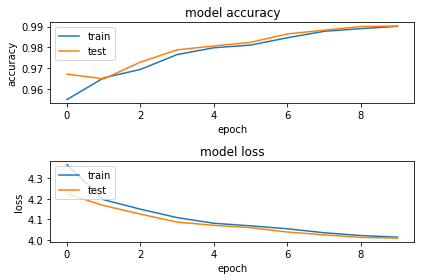

In [51]:
# plot the accuracy and loss and save the model

plt.figure(1)
# summarize history for accuracy

plt.subplot(211)
plt.plot(histories['acc']) 
plt.plot(histories['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(histories['loss'])
plt.plot(histories['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()

# save the model so that it can be loaded later
# file name will be "model_v<version>_<numberofsongs>_save_<samplesperchunk>_<chunksperbeat>_<beatspersequence>_e<numberofepochs>.hdf5"
new_model.save('model_v' + str(model_version) + 
               '_n' + str(len(song_list)) + 
               '_save_' + str(samples_per_chunk) + 
               '_' + str(chunks_per_beat) + 
               '_' + str(beats_per_sequence) + 
               '_e' + str(len(histories['val_loss'])) + '.hdf5')

plt.show()

### Create

In [52]:
nn_song, bpm = get_predict_song("song88.ogg", samples_per_chunk, chunks_per_beat, beats_per_sequence)

In [53]:
nn_out = new_model.predict(nn_song)

In [54]:
export_beatmap("Easy.json", nn_out, chunks_per_beat, bpm, 
               division=nn_out.shape[1]//2)

In [33]:
nn_out.shape

(1928, 128, 3, 4, 13)

## Utility functions and testing

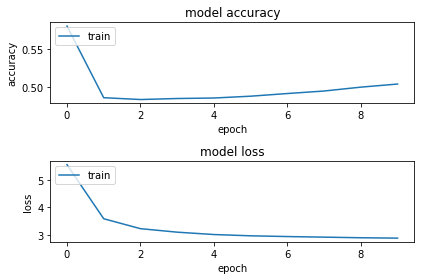

In [36]:
plt.figure(1)
# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()

plt.show()

In [22]:
#print('Accuracy:', new_model.evaluate(X,Y)[1]*100.0,'%')

32657/32657 [==============================] - 330s 10ms/step
Accuracy: 56.28276938801756 %


In [63]:
print('Test_Accuracy:', new_model.evaluate(x_test,y_test)[1]*100.0,'%')

419/419 [==============================] - 2s 4ms/step
Test_Accuracy: 48.707084083898536 %


In [98]:
histories['val_loss'] += history.history['val_loss']
histories['val_acc'] += history.history['val_acc']
histories['loss'] += history.history['loss']
histories['acc'] += history.history['acc']

In [133]:
data_version = 1

In [134]:
model_version = 1